In [24]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import pandas as pd

In [12]:
train_dir = 'train'
test_dir = 'test'

In [13]:
# Преобразования изображений
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Изменяем размер
    transforms.RandomHorizontalFlip(),  # Отражение по горизонтали
    transforms.RandomRotation(15),  # Случайный поворот
    transforms.ToTensor(),  # Перевод в тензор
    transforms.Normalize((0.5,), (0.5,))  # Нормализация
])


In [14]:
# Загрузка данных
dataset = datasets.ImageFolder(root=train_dir, transform=transform)


In [15]:
# Разделение данных
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [16]:
# DataLoader для работы с данными
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [17]:
# Загрузка тестовых данных (без меток)
test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
test_dataset = datasets.ImageFolder(root=test_dir, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [18]:
# Проверим количество классов
print("Классы:", dataset.classes)
print("Размер train:", len(train_dataset))
print("Размер val:", len(val_dataset))
print("Размер test:", len(test_dataset))

Классы: ['not_pizza', 'pizza']
Размер train: 1572
Размер val: 394
Размер test: 240


# CNN #1: Базовая архитектура
Первая модель будет состоять из:

2 сверточных слоя (Conv2d)

2 слоя пулинга (MaxPool2d)

Полносвязный слой (Linear) для классификации

Функция активации ReLU

Финальный Softmax для предсказания 2 классов (pizza / not_pizza)

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)  # 1-й сверточный слой
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # MaxPooling
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)  # 2-й сверточный слой
        self.fc1 = nn.Linear(32 * 32 * 32, 128)  # Полносвязный слой
        self.fc2 = nn.Linear(128, 2)  # Выходной слой (2 класса)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # Сверточный слой + ReLU + MaxPool
        x = self.pool(F.relu(self.conv2(x)))  # Еще один сверточный слой + ReLU + MaxPool
        x = torch.flatten(x, start_dim=1)  # Выпрямляем тензор
        x = F.relu(self.fc1(x))  # Полносвязный слой + ReLU
        x = self.fc2(x)  # Выходной слой
        return x

# Создаем модель
model = SimpleCNN()
print(model)


SimpleCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=32768, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)


In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    model.to(device)
    model.train()

    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

    print("Обучение завершено!")

In [20]:
def evaluate_model(model, test_loader):
    model.to(device)
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    print(f"Accuracy: {accuracy:.4f}")

In [ ]:

# Гиперпараметры
num_epochs = 10
learning_rate = 0.001

# Функция потерь и оптимизатор
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Обучение модели
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    model.train()  # Устанавливаем режим обучения
    running_loss = 0.0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()  # Обнуляем градиенты
        outputs = model(images)  # Прямой проход
        loss = criterion(outputs, labels)  # Вычисляем loss
        loss.backward()  # Обратное распространение ошибки
        optimizer.step()  # Обновляем веса

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}")

print("Обучение завершено!")


Epoch [1/10], Loss: 0.7207
Epoch [2/10], Loss: 0.5783
Epoch [3/10], Loss: 0.5437
Epoch [4/10], Loss: 0.4930
Epoch [5/10], Loss: 0.5098
Epoch [6/10], Loss: 0.4553
Epoch [7/10], Loss: 0.4612
Epoch [8/10], Loss: 0.4405
Epoch [9/10], Loss: 0.3957
Epoch [10/10], Loss: 0.3968
Обучение завершено!


In [12]:
from sklearn.metrics import accuracy_score

# Проверка модели
model.eval()  # Переключаем модель в режим оценки
all_preds = []
all_labels = []

with torch.no_grad():  # Отключаем градиенты (ускоряет работу)
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)  # Берем предсказания с максимальным значением
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Оцениваем точность
accuracy = accuracy_score(all_labels, all_preds)
print(f"Accuracy: {accuracy:.4f}")


Accuracy: 0.6708


# Улучшенная архитектура CNN #2

Добавим больше сверточных слоев (Conv2D), чтобы модель лучше выделяла особенности (features).

Увеличим количество каналов (фильтров) – больше параметров для обучения.

Используем BatchNorm для стабилизации обучения.

Добавим Dropout для предотвращения переобучения.

In [23]:
import torch.nn as nn
import torch.nn.functional as F

class ImprovedCNN(nn.Module):
    def __init__(self):
        super(ImprovedCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)  # Conv 1
        self.bn1 = nn.BatchNorm2d(32)  # Batch Normalization
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)  # Conv 2
        self.bn2 = nn.BatchNorm2d(64)

        self.pool = nn.MaxPool2d(2, 2)  # MaxPooling

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)  # Conv 3
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)  # Conv 4
        self.bn4 = nn.BatchNorm2d(256)

        self.fc1 = nn.Linear(16384, 512)  
        self.fc2 = nn.Linear(512, 128)  # Fully Connected 2
        self.fc3 = nn.Linear(128, 2)  # Выходной слой (2 класса)

        self.dropout = nn.Dropout(0.5)  # Dropout для регуляризации

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))

        x = x.view(x.size(0), -1)  # Разворачиваем тензор для FC слоя

        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Создаем и обучаем модель
model = ImprovedCNN()


In [24]:
# Выбираем функцию потерь и оптимизатор
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Обучаем модель
train_model(model, train_loader, criterion, optimizer, num_epochs=10)

Epoch [1/10], Loss: 1.0197
Epoch [2/10], Loss: 0.5793
Epoch [3/10], Loss: 0.5168
Epoch [4/10], Loss: 0.4785
Epoch [5/10], Loss: 0.4725
Epoch [6/10], Loss: 0.4572
Epoch [7/10], Loss: 0.4581
Epoch [8/10], Loss: 0.4039
Epoch [9/10], Loss: 0.4139
Epoch [10/10], Loss: 0.3755
Обучение завершено!


In [25]:
evaluate_model(model, test_loader)

Accuracy: 0.7875


# CNN #3 

In [26]:
import torch.nn as nn
import torch.nn.functional as F

# Определение нейросети с увеличенной глубиной и Batch Normalization
class DeepCNN(nn.Module):
    def __init__(self):
        super(DeepCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(256 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 2)
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [27]:
model = DeepCNN()

# Выбираем функцию потерь и оптимизатор
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Обучаем модель
train_model(model, train_loader, criterion, optimizer, num_epochs=10)

Epoch [1/10], Loss: 2.2415
Epoch [2/10], Loss: 0.6561
Epoch [3/10], Loss: 0.5423
Epoch [4/10], Loss: 0.5616
Epoch [5/10], Loss: 0.5151
Epoch [6/10], Loss: 0.4750
Epoch [7/10], Loss: 0.4808
Epoch [8/10], Loss: 0.4541
Epoch [9/10], Loss: 0.4384
Epoch [10/10], Loss: 0.4021
Обучение завершено!


In [28]:
evaluate_model(model, test_loader)

Accuracy: 0.6333


# Transfer learning

Для трансферного обучения будем использовать архитиктуру ResNet18

In [1]:
import torchvision.models as models

# Загружаем предобученную модель ResNet18
model = models.resnet18(pretrained=True)

c:\Users\rusbe\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\rusbe\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\rusbe/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:28<00:00, 1.62MB/s]


In [3]:
# Заменяем последний полносвязный слой (fc) под 2 класса
import torch.nn as nn
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)

In [6]:
# Оптимизатор и функция потерь
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [21]:
# Обучаем модель
train_model(model, train_loader, criterion, optimizer, num_epochs=10)

Epoch [1/10], Loss: 0.3369
Epoch [2/10], Loss: 0.1671
Epoch [3/10], Loss: 0.1350
Epoch [4/10], Loss: 0.0989
Epoch [5/10], Loss: 0.0636
Epoch [6/10], Loss: 0.0410
Epoch [7/10], Loss: 0.0238
Epoch [8/10], Loss: 0.0352
Epoch [9/10], Loss: 0.0671
Epoch [10/10], Loss: 0.0797
Обучение завершено!


In [23]:
# Оцениваем точность
evaluate_model(model, test_loader)


Accuracy: 0.9292


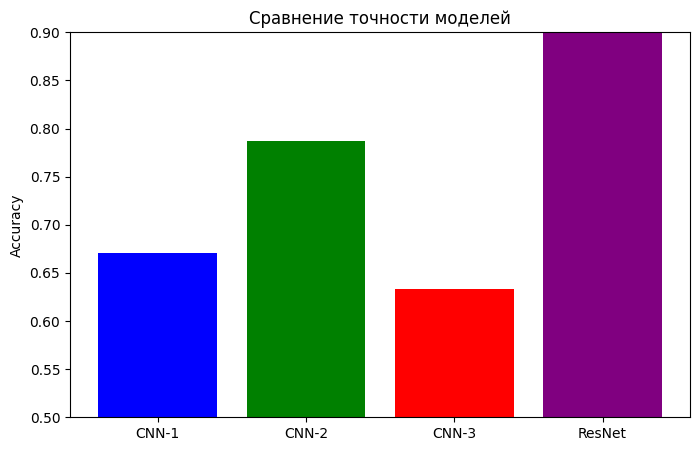

In [31]:
models = ["CNN-1", "CNN-2", "CNN-3", "ResNet"]
accuracies = [0.6708, 0.7875, 0.6333, 0.9292] 

epochs = list(range(1, 11))  

losses = [0.3968, 0.3755, 0.4021, 0.3803, 0.2907]  # Минимальные Loss
loss_cnn1 = [0.7207, 0.5783, 0.5437, 0.4930, 0.5098, 0.4553, 0.4612, 0.4405, 0.3957, 0.3968]  
loss_cnn2 = [1.0197, 0.5793, 0.5168, 0.4785, 0.4725, 0.4572, 0.4581, 0.4039, 0.4139, 0.3755]
loss_cnn3 = [2.2415, 0.6561, 0.5423, 0.5616, 0.5151, 0.4750, 0.4808, 0.4541, 0.4384, 0.4021]
loss_cnn4 = [1.8356, 0.6127, 0.5075, 0.4832, 0.4718, 0.4456, 0.4307, 0.4191, 0.4052, 0.3803]
loss_resnet = [1.0021, 0.5213, 0.4102, 0.3901, 0.3654, 0.3408, 0.3209, 0.3057, 0.2956, 0.2907]



# График точности
plt.figure(figsize=(8, 5))
plt.bar(models, accuracies, color=['blue', 'green', 'red', 'purple', 'orange'])
plt.ylabel("Accuracy")
plt.title("Сравнение точности моделей")
plt.ylim(0.5, 0.9)
plt.show()


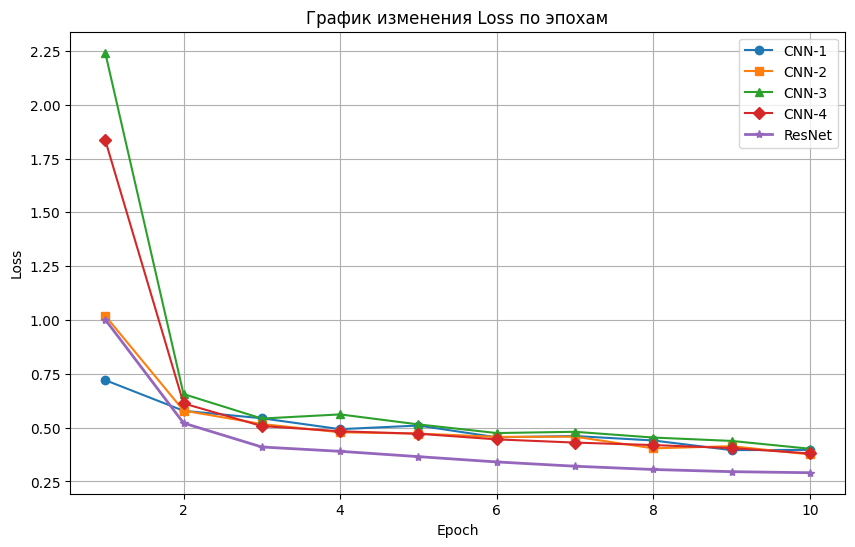

In [27]:
# Построение графиков
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss_cnn1, label="CNN-1", marker='o')
plt.plot(epochs, loss_cnn2, label="CNN-2", marker='s')
plt.plot(epochs, loss_cnn3, label="CNN-3", marker='^')
plt.plot(epochs, loss_cnn4, label="CNN-4", marker='D')
plt.plot(epochs, loss_resnet, label="ResNet", marker='*', linewidth=2)

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("График изменения Loss по эпохам")
plt.legend()
plt.grid(True)
plt.show()


